# Initiate random dataset

In [61]:
import random
import numpy as np
from faker import Factory

### Simulation parameters

MAX_REPO_COMMIT_COUNT = 4000
MAX_PUSH_COMMIT_COUNT = 10
NUMBER_OF_REPOS = 400
NUMBER_OF_USERS = 1000
NUMBER_OF_PUSHS = 1000
NUMBER_OF_RATINGS = 100
AVERALL_AVERAGE_RATE = 0.7
RATES = ['doc', 'support', 'code_quality']

faker = Factory.create()

# repos are mapped by id
repos = {}
# users are mapped by id
users = {}

def bound_rating(rating, minimum=0, maximum=5):
    return min(max(minimum, rating), maximum)

def noise(user_karma):
    return np.random.normal(0, 1)/user_karma

def biaised_rate(user_karma, true_ratings):
    rating = -1
    if true_ratings == []:
        rating = np.random.binomial(5, AVERALL_AVERAGE_RATE)
    else:
        rating = np.random.binomial(5, np.mean(true_ratings)/5.1) 
    return bound_rating(rating + noise(user_karma))

print "Generating repos ..."
for i in range(0, NUMBER_OF_REPOS):
    repos[str(i)] = {
        'id': i, 
        'repo_name': faker.domain_word(), 
        'true_ratings': {rate: biaised_rate(1, []) for rate in RATES},
        'karma_weight_of_score': 1,
        'ratings': {},
        'score': -1,
        'commit_count': 0,
        'contributors': {}
    }
print "-> %d repos generated" % len(repos.keys())


print "Generating users ..."
for i in range(0, NUMBER_OF_USERS):
    users[str(i)] = {
        'id': i, 
        'username': faker.user_name(), 
        'karma': 0.5, # at first, everyone has the same karma
        'contributions': {}, # key id of the repository, value number of contributions
        'ratings': {}
    }
print "-> %d users generated" % len(users.keys())
    
    
print "Generating contributions ..."
total_commit_count = 0
for i in range(0, NUMBER_OF_PUSHS ):
    contrib_repo_id = str(random.randint(0, NUMBER_OF_REPOS - 1))
    contrib_user_id = str(random.randint(0, NUMBER_OF_USERS - 1))
    contrib_commit_count = random.randint(1, MAX_PUSH_COMMIT_COUNT - 1)
    
    if repos[contrib_repo_id]['commit_count'] + contrib_commit_count < MAX_REPO_COMMIT_COUNT:
        repos[contrib_repo_id]['commit_count'] += contrib_commit_count
        total_commit_count += contrib_commit_count
        
        # Mapping contributions from user to repos
        if contrib_repo_id in users[contrib_user_id]['contributions']:
            users[contrib_user_id]['contributions'][contrib_repo_id] += contrib_commit_count
        else:
            users[contrib_user_id]['contributions'][contrib_repo_id] = contrib_commit_count
        
        # Mapping contributions from repos to users
        if contrib_user_id in repos[contrib_repo_id]['contributors']:
            repos[contrib_repo_id]['contributors'][contrib_user_id] += contrib_commit_count
        else:
            repos[contrib_repo_id]['contributors'][contrib_user_id] = contrib_commit_count
print "-> %d commits generated" % total_commit_count

Generating repos ...
-> 400 repos generated
Generating users ...
-> 1000 users generated
Generating contributions ...
-> 4932 commits generated


In [62]:
#the biggest the number of commit the highest the chance of being rated
import pandas as pd
import numpy as np

repos_pd = pd.DataFrame.from_dict(repos, orient='index')
repos_pd.sort(['commit_count'], ascending=[0], inplace=True)

def get_weighted_random_repo_id():
    from math import log
    beta = NUMBER_OF_REPOS / ( 10 * log(2)) # median around NUMBER_OF_REPOS / 10
    return repos_pd.index[min(np.random.exponential(beta), NUMBER_OF_REPOS-1)]
    
def compute_score_from_rating(rating):
    return (rating['doc'] + rating['code_quality'] + rating['support']) / 3

def update_score(repo, user, rating):
    if repo['score'] == -1:
        repo['score'] = compute_score_from_rating(rating)
    else:
        repo['score'] = (repo['karma_weight_of_score'] * repo['score'] + user['karma'] * compute_score_from_rating(rating)) / (repo['karma_weight_of_score'] + user['karma'])
    
def update_karma_weight(repo, karma):
    repo['karma_weight_of_score'] += karma
    
def scoreRepo(userId, repoId, rating):
    if rating['doc'] is None or rating['code_quality'] is None or rating['support'] is None:
        print "Can't vote, missing one argument"
    else:
        # Basic implementation of scoring algorithm
        repo = repos[repoId]
        user = users[userId]
        repo['ratings'][userId] = rating
        user['ratings'][repoId] = rating
        update_score(repo, user, rating)
        update_karma_weight(repo, user['karma'])
        propagateScoreChange(repoId)
        
def propagateScoreChange(repoId):
    currentRepo = repos[repoId]
    for userId, contributions in repos[repoId]['contributors'].iteritems():
        # Basic implementation of propagation algorithm
        users[userId]['karma'] = ( users[userId]['karma'] + (contributions / float(currentRepo['commit_count'])) * currentRepo['score']) / 2
    
print "Generating scores ..."
total_scoring_count = 0
for i in range(0, NUMBER_OF_RATINGS):
    while True:
        scoring_repo_id = get_weighted_random_repo_id()
        if repos[scoring_repo_id]['contributors'] != {}:
            break
    none_contributing_users = list(set(users.keys()) - set(repos[scoring_repo_id]['contributors'].keys()))
    scoring_user_id = random.choice(none_contributing_users)
    
    repo = repos[scoring_repo_id]
    ratings = repo['ratings'].itervalues()
    true_ratings = repo['true_ratings']
    rating ={arg: biaised_rate(users[scoring_user_id]['karma'], [true_ratings[arg]]) for arg in RATES}

    scoreRepo(scoring_user_id, scoring_repo_id, rating)
    total_scoring_count += 1

Generating scores ...


# Info plots on the generated dataset

## Contributions distribution

In [63]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

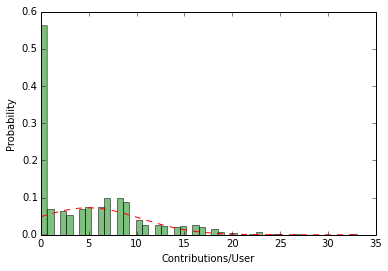

In [64]:
contributions = []

for user_id, user in users.iteritems():

    acc = 0
    for repo_id, contribs in user['contributions'].iteritems():
        acc += contribs
    
    contributions.append(acc)

n, bins, patches = plt.hist(contributions, 50, normed=True, facecolor='green', alpha=0.5)

mu = np.mean(contributions)
sigma = np.std(contributions)

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, '--r')
plt.xlabel('Contributions/User')
plt.ylabel('Probability')
plt.show()

## Karma Distribution

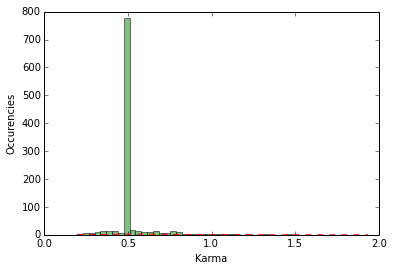

In [65]:
karmas = []

for user_id, user in users.iteritems():
    karmas.append(user['karma'])

n, bins, patches = plt.hist(karmas, 50, facecolor='green', alpha=0.5)

mu = np.mean(karmas)
sigma = np.std(karmas)

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, '--r')
plt.xlabel('Karma')
plt.ylabel('Occurencies')
plt.show()

## Score Distribution

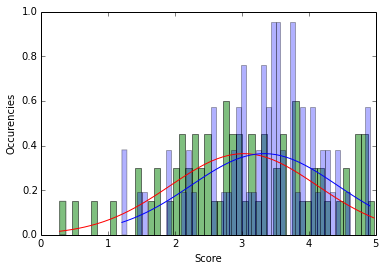

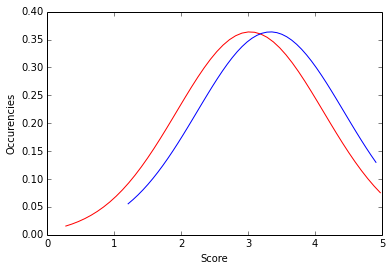

In [66]:
scores = []
true_scores = []
for repo_id, repo in repos.iteritems():
    if repo['score'] > 0:
        scores.append(repo['score'])
        true_scores.append(np.mean(repo['true_ratings'].values()))

n, bins, patches = plt.hist(scores, 50, normed=True, facecolor='green', alpha=0.5)
n, true_bins, true_patches = plt.hist(true_scores, 50, normed=True, facecolor='blue', alpha=0.3)

mu = np.mean(scores)
sigma = np.std(scores)
true_mu = np.mean(true_scores)
true_sigma = np.std(scores)

y = mlab.normpdf(bins, mu, sigma)
true_y = mlab.normpdf(true_bins, true_mu, true_sigma)
plt.plot(bins, y, 'r')
plt.plot(true_bins, true_y, 'b')
plt.xlabel('Score')
plt.ylabel('Occurencies')
plt.show()

plt.plot(bins, y, 'r')
plt.plot(true_bins, true_y, 'b')
plt.xlabel('Score')
plt.ylabel('Occurencies')
plt.show()

##Global Score Distribution

In [245]:
import pymc

ratings = {}
for repo_id, repo in repos.iteritems():
    ratings.update(repo['ratings'])
ratings_pd = pd.DataFrame.from_dict(ratings, orient='index')

 [-----------------100%-----------------] 10000 of 10000 complete in 0.9 secPlotting code_quality_prior
Plotting doc_prior
Plotting support_prior


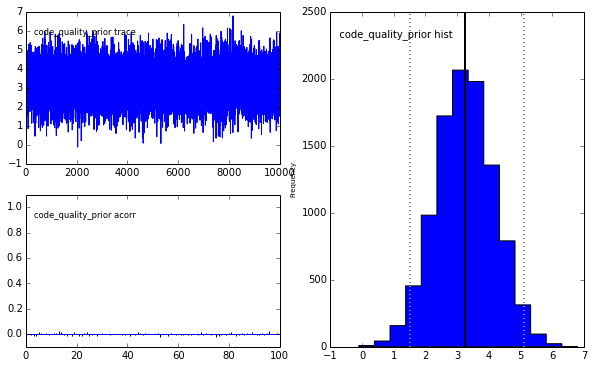

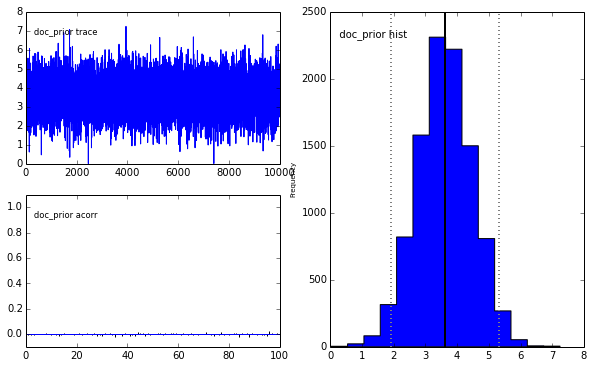

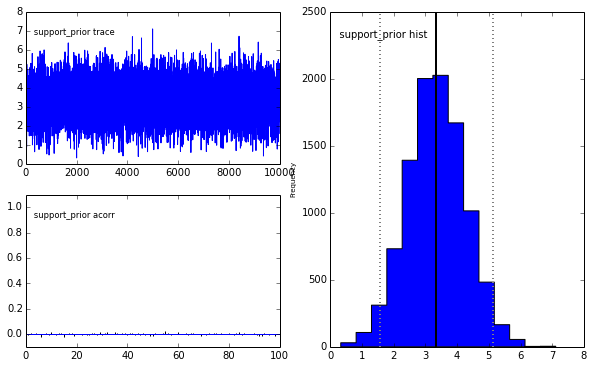

In [246]:
priors = {}
for c in ratings_pd.columns:
    priors[c] = pymc.Normal(c+'_prior', mu=ratings_pd[c].mean(), tau=ratings_pd[c].std())

#plot priors
sampler = pymc.MCMC(priors.values())
sampler.sample(iter=10000)
pymc.Matplot.plot(sampler)

## Repos Score Distribution

In [33]:
tau = pymc.Normal('tau', mu=0, tau=.01)

docs = {}
for repo_id, repo in repos.iteritems():
    ratings = pd.DataFrame.from_dict(repo['ratings'], orient='index')
    if(not ratings.empty):
        docs[repo_id] = pymc.Normal('doc_'+repo_id, 
                                    mu=priors['doc'],
                                    value=np.array(ratings['doc']).astype(float),
                                    observed=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 11.2 secPlotting doc_prior
Plotting support_prior
Plotting tau
Plotting code_quality_prior


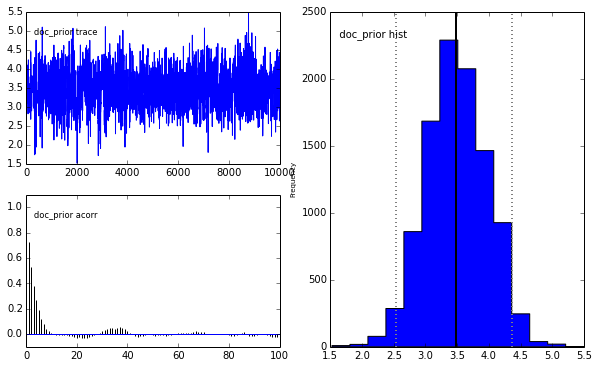

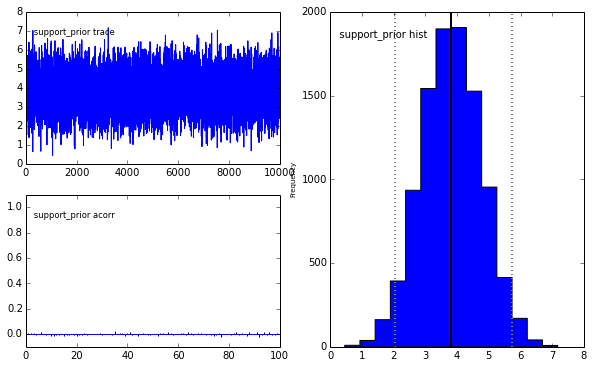

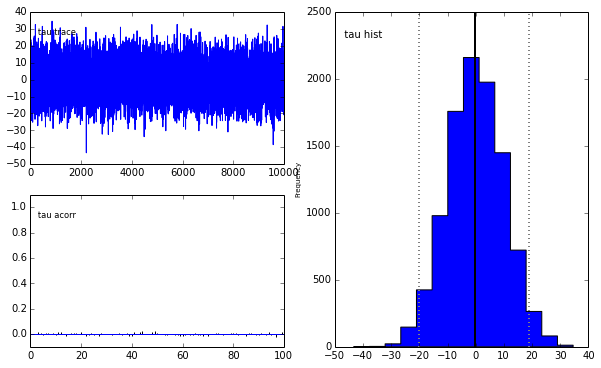

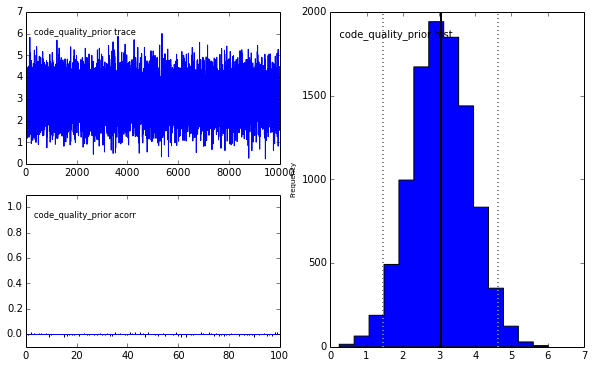

In [34]:
sampler = pymc.MCMC(docs.values() + priors.values() + [tau])
sampler.sample(iter=10000)
pymc.Matplot.plot(sampler)